Using device: cuda


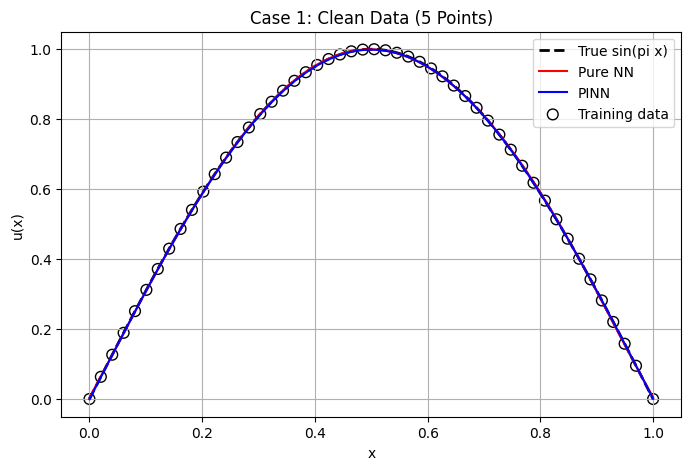

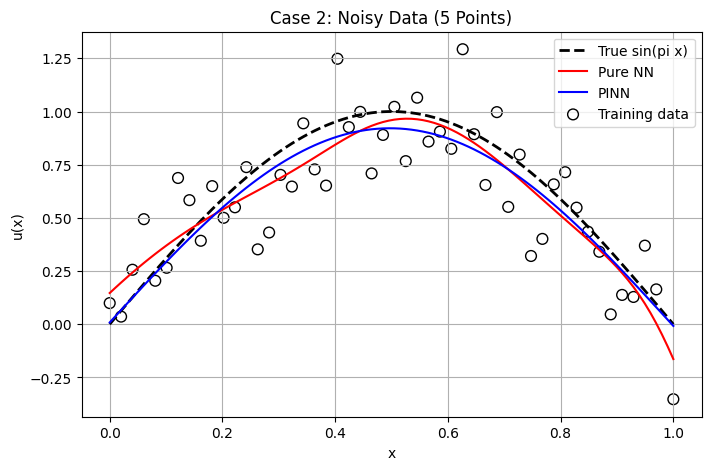

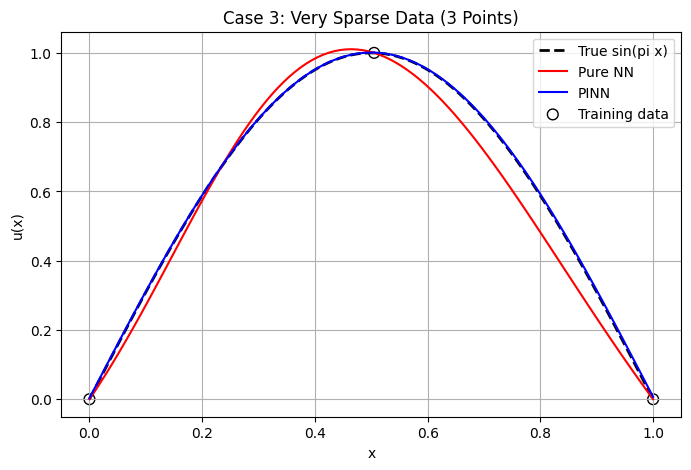

In [3]:
# %%
# ===============================================================
# Physics-Informed Neural Networks vs Pure Neural Networks
# How PINNs need less data by using physics as a regularizer
# ===============================================================

import torch, torch.nn as nn, torch.autograd as autograd
import numpy as np, matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# %%
# ---------------------------------------------------------------
# Define the true physical system: u''(x) + pi^2 u = 0
# Analytical solution: u(x) = sin(pi x)
# ---------------------------------------------------------------

def true_function(x):
    return np.sin(np.pi * x)

# training x domain
x_true = np.linspace(0, 1, 100).reshape(-1, 1)
u_true = true_function(x_true)

# Utility function for creating tensors
def to_torch(arr):
    return torch.tensor(arr, dtype=torch.float32, device=device)

# %%
# ---------------------------------------------------------------
# Define a simple neural network
# ---------------------------------------------------------------
class SmallNN(nn.Module):
    def __init__(self, hidden=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, hidden), nn.Tanh(),
            nn.Linear(hidden, hidden), nn.Tanh(),
            nn.Linear(hidden, 1)
        )
    def forward(self, x): return self.net(x)

# ---------------------------------------------------------------
# Define a training helper
# ---------------------------------------------------------------
def train_models(x_data, u_data, noise=False, title="Clean Data"):
    """
    Train a pure NN and a PINN on given data.
    Returns their predictions over [0,1].
    """
    x_true_t = to_torch(x_true)
    u_true_t = to_torch(u_true)
    x_data_t = to_torch(x_data)
    u_data_t = to_torch(u_data)

    # 1️⃣ Plain NN
    nn_model = SmallNN().to(device)
    opt = torch.optim.Adam(nn_model.parameters(), lr=1e-3)
    for epoch in range(4000):
        opt.zero_grad()
        pred = nn_model(x_data_t)
        loss = ((pred - u_data_t)**2).mean()
        loss.backward(); opt.step()

    # 2️⃣ PINN
    pinn_model = SmallNN().to(device)
    opt_pinn = torch.optim.Adam(pinn_model.parameters(), lr=1e-3)
    x_phys = torch.linspace(0, 1, 100, device=device).view(-1, 1)
    x_phys.requires_grad_(True)

    for epoch in range(4000):
        opt_pinn.zero_grad()
        u_pred_data = pinn_model(x_data_t)
        loss_data = ((u_pred_data - u_data_t)**2).mean()

        u_pred = pinn_model(x_phys)
        du = autograd.grad(u_pred, x_phys, torch.ones_like(u_pred), create_graph=True)[0]
        duu = autograd.grad(du, x_phys, torch.ones_like(du), create_graph=True)[0]
        loss_phys = ((duu + (np.pi**2)*u_pred)**2).mean()

        u0 = pinn_model(torch.tensor([[0.0]], device=device))
        u1 = pinn_model(torch.tensor([[1.0]], device=device))
        loss_bc = (u0**2 + u1**2).mean()

        loss = loss_data + loss_phys + loss_bc
        loss.backward(); opt_pinn.step()

    # Predictions
    with torch.no_grad():
        u_nn = nn_model(x_true_t).cpu().numpy()
        u_pinn = pinn_model(x_true_t).cpu().numpy()

    # Plot comparison
    plt.figure(figsize=(8,5))
    plt.plot(x_true, u_true, 'k--', lw=2, label="True sin(pi x)")
    plt.plot(x_true, u_nn, 'r', label="Pure NN")
    plt.plot(x_true, u_pinn, 'b', label="PINN")
    plt.scatter(x_data, u_data, s=60, facecolor='none', edgecolor='k', label='Training data')
    plt.legend()
    plt.title(f"{title}")
    plt.xlabel("x"); plt.ylabel("u(x)")
    plt.grid(True)
    plt.show()

# %%
# ---------------------------------------------------------------
# Case 1: Clean Data (5 points)
# ---------------------------------------------------------------
idx = np.linspace(0, 99, 50).astype(int)
x_data = x_true[idx]
u_data = u_true[idx]
train_models(x_data, u_data, title="Case 1: Clean Data (5 Points)")

# %%
# ---------------------------------------------------------------
# Case 2: Noisy Data (5 points, with Gaussian noise)
# ---------------------------------------------------------------
np.random.seed(42)
u_noisy = np.sin(np.pi*x_data) + 0.2*np.random.randn(*x_data.shape)
train_models(x_data, u_noisy, noise=True, title="Case 2: Noisy Data (5 Points)")

# %%
# ---------------------------------------------------------------
# Case 3: Sparse Data (only 3 points)
# ---------------------------------------------------------------
idx = np.array([0, 50, 99])  # Only 3 data points
x_sparse = x_true[idx]
u_sparse = u_true[idx]
train_models(x_sparse, u_sparse, title="Case 3: Very Sparse Data (3 Points)")
